# Raw Image Exploration

This notebook details functions and attempts to preprocess the raw resistor image data into a usable format. 
Various strategies such as contouring and filtering were explored.
The conclusions from these experiments are detailed on the last cell.

## Overview
We have pictures of resistors. Our goal is to reduce noise in the image to a point where the data can be easily labelled and easy for a machine learning model to understand.  

If possible, we can also directly extract regions of interest through classical computer vision functions such as contouring.

In [29]:
# Bootstrap
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

def buildName(args):
    name = ""
    for arg in args:
        if name != "":
            name += "-"
        name += arg
    return name
        
def getFilename(name):
    return name + ".jpg"

BROWN = "brown"
BLACK = "black"
RED = "red"
ORANGE  = "orange"
YELLOW = "yellow"
GREEN = "green"
BLUE = "blue"
PURPLE = "purple"
GREY = "grey"
SILVER = "silver"
GOLD = "gold"
WHITE = "white"

# Histogram
histSz = [256]
histRange = [0, 256]

# Convenience wrapper
class Resistor:
    # input colors Left 2 Right 
    def __init__(self, *colorsL2R):
        self.name = buildName(colorsL2R)
        self.img = cv.imread("data/exploratory/" + getFilename(self.name))

# Plot wrapper
def plot(image: cv.Mat, caption=""):
    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.axis('off')
    plt.title(caption)
    plt.imshow(image_rgb)

# Convenience function wrapper
def util_convertRGB(image: cv.Mat):
    return cv.cvtColor(image, cv.COLOR_BGR2RGB)

def plot_resistor(resistor: Resistor):
    plot(resistor.img, resistor.name)

def plot_N_resistors(resistors: list):
    fig, axes = plt.subplots(1, len(resistors), figsize=(10, 30))
    for i, r in enumerate(resistors):
        mat = util_convertRGB(r.img)
        axes[i].imshow(mat)
        axes[i].set_title(r.name)
        axes[i].axis('off')

# Plot N images side by side
def plot_N_continuous(*matTitleTuple):
    fig, axes = plt.subplots(1, len(matTitleTuple), figsize=(20, 20))
    for i, (mat, title) in enumerate(matTitleTuple):
        mat = util_convertRGB(mat)
        axes[i].imshow(mat)
        axes[i].set_title(title)
        axes[i].axis('off')


def plot_N_hist(*matTitleTuple):
    fig, axes = plt.subplots(1, len(matTitleTuple), figsize=(20, 10))
    for i, (mat, title) in enumerate(matTitleTuple):
        # mat = util_convertRGB(mat)
        print(len(mat.shape))
        if len(mat.shape) == 2: #grayscale
            hist = cv.calcHist([mat], [0], None, [256], [0, 256])
            axes[i].plot(hist)
            axes[i].set_title(title)
            axes[i].set_xlabel('Intensity')
            axes[i].set_ylabel('Frequency')
        elif len(mat.shape) == 3: #RGB
            histB = cv.calcHist([img], [0], None, histSz, histRange, accumulate=False)
            histR = cv.calcHist([img], [1], None, histSz, histRange, accumulate=False)
            histG = cv.calcHist([img], [2], None, histSz, histRange, accumulate=False)
            # Plot the histogram of the RGB image
            axes[i].plot(histR, color="red", label="Red")
            axes[i].plot(histG, color="green", label="Green")
            axes[i].plot(histB, color="blue", label="Blue")
        else:
            print("Unknown matrix.")

def plotHistGrayscale(img: cv.Mat):
    img = img.astype(np.uint8)  # Convert image to uint8 data type
    hist = cv.calcHist([img], [0], None, [256], [0, 256])
    plt.plot(hist)
    plt.xlabel('Pixel')
    plt.ylabel('Frequency')
    plt.show()

# Setup data
resistors = []
r1 = Resistor(BROWN, BLACK, BLACK, ORANGE, BROWN)
r2 = Resistor(BROWN, BLACK, BLACK, RED, BROWN)
r3 = Resistor(BROWN, BLACK, BLACK, BROWN, BROWN)
r4 = Resistor(BLUE, GREY, SILVER, GOLD)
r5 = Resistor(RED, PURPLE, SILVER, GOLD)
r6 = Resistor(ORANGE, WHITE, SILVER, GOLD)
resistors.extend([r1,r2,r3,r4,r5, r6])


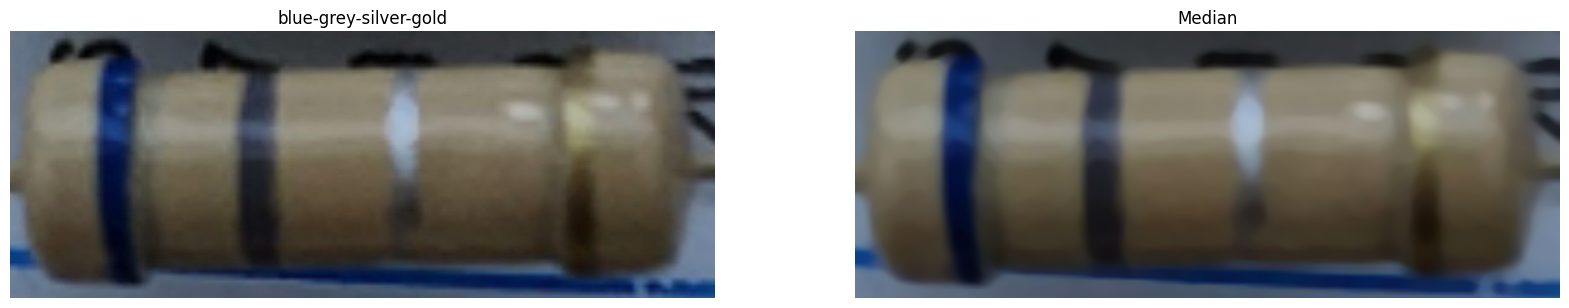

In [30]:
# ----- Filter Testing ----- Exploratory image cleaning test
resistor_raw = r4
# plot_resistor(resistor_raw)
img = resistor_raw.img.copy()
ksize = (9,9)

# Normalized box filter
blur = cv.blur(img, ksize=ksize)

# Gaussian blur
sigmaX = 3.9
# control the stddev of gauss curve spread
# the higher sigmaX, the more blur 
gauss = cv.GaussianBlur(img, ksize=ksize, sigmaX=sigmaX)

# Median blur
median_sz = 27
median = cv.medianBlur(img, ksize=median_sz)

# Bilateral blur
di = 10 # diameter of pixel neighbourhood
sigClr = 15 # stddev of colorspace.
# neighbors with similar color val = more filter influence
# This preserves edges while reducing noise. 
sigSpace = 10 # stddev of coordinate space
# larger val -> larger filter areas
bilat = img.copy()
bilat = cv.bilateralFilter(img, d=di, sigmaColor=sigClr, sigmaSpace=sigSpace, dst=bilat)

plot_N_continuous(
    (img, resistor_raw.name),
    # (blur, "Norm Box"),
    # (gauss, "Gaussian"),
    (median, "Median"),
    # (bilat, "Bilateral"),
)

def iterate_bilateral():
    di = 3 # diameter of pixel neighbourhood
    sigClr = 15 # stddev of colorspace.
    # neighbors with similar color val = more filter influence
    # This preserves edges while reducing noise. 
    sigSpace = 10 # stddev of coordinate space
    # larger val -> larger filter areas
    for i in range(10):
        # Bilateral blur
        bilat = img.copy()
        bilat = cv.bilateralFilter(img, d=di, sigmaColor=sigClr, sigmaSpace=sigSpace, dst=bilat)
        plot_N_continuous(
            (img, resistor_raw.name),
            (bilat, "SC: " + str(sigClr)),
        )
        di += 3

# Final function to use based on above experimentation
# def chosen_smoothing(img: cv.Mat):
#     # Use bilateral filtering
#     di = 10 # diameter of pixel neighbourhood
#     sigClr = 15 # stddev of colorspace.
#     # neighbors with similar color val = more filter influence
#     # This preserves edges while reducing noise. 
#     sigSpace = 10 # stddev of coordinate space
#     # larger val -> larger filter areas
#     bilat = img.copy()
#     bilat = cv.bilateralFilter(img, d=di, sigmaColor=sigClr, sigmaSpace=sigSpace)
#     return bilat

def chosen_smoothing(img: cv.Mat, sz=55):
    return cv.medianBlur(img, sz)


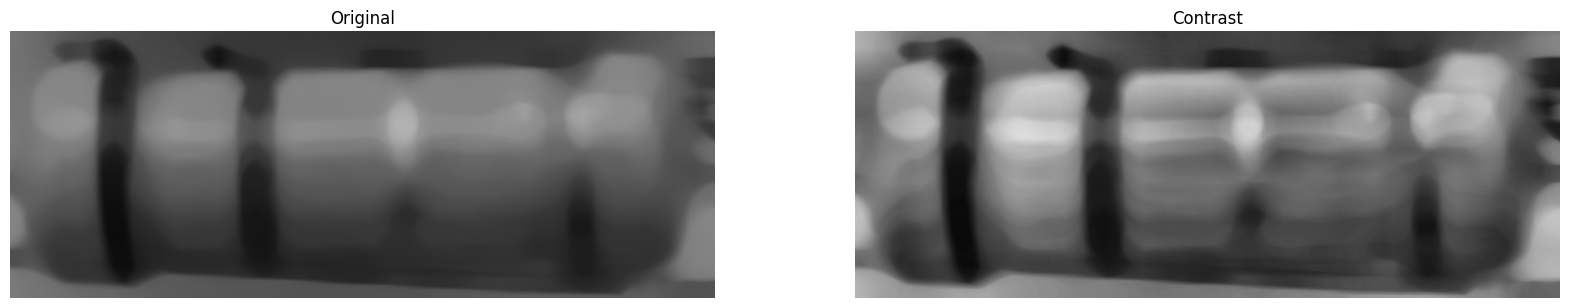

In [31]:
# --- IMPROVE CONTRAST ---

def chosen_smoothing(img: cv.Mat, sz=55):
    return cv.medianBlur(img, sz)

img = r4.img
img = chosen_smoothing(img)

# Increase contrast (using LAB color scheme)
# LAB: https://en.wikipedia.org/wiki/CIELAB_color_space#Advantages 
lab = cv.cvtColor(img, cv.COLOR_BGR2LAB)
l, a, b = cv.split(lab)
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
# Improve lighting using: Contrast Limited Adaptive Histogram Equalization
l_eq = clahe.apply(l)
# Re-merge
lab_eq = cv.merge((l_eq, a, b))
img_contrast = cv.cvtColor(lab_eq, cv.COLOR_LAB2BGR)

img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_contrast_gray = cv.cvtColor(img_contrast, cv.COLOR_BGR2GRAY)

plot_N_continuous(
    (img_gray, "Original"),
    (img_contrast_gray, "Contrast")
)

def apply_contrast(img):
    lab = cv.cvtColor(img, cv.COLOR_BGR2LAB)
    l, a, b = cv.split(lab)
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # Improve lighting using: Contrast Limited Adaptive Histogram Equalization
    l_eq = clahe.apply(l)
    # Re-merge
    lab_eq = cv.merge((l_eq, a, b))
    img_contrast = cv.cvtColor(lab_eq, cv.COLOR_LAB2BGR)
    # Contrast benefits from median blur (we cannot tolerate noise)
    return img_contrast

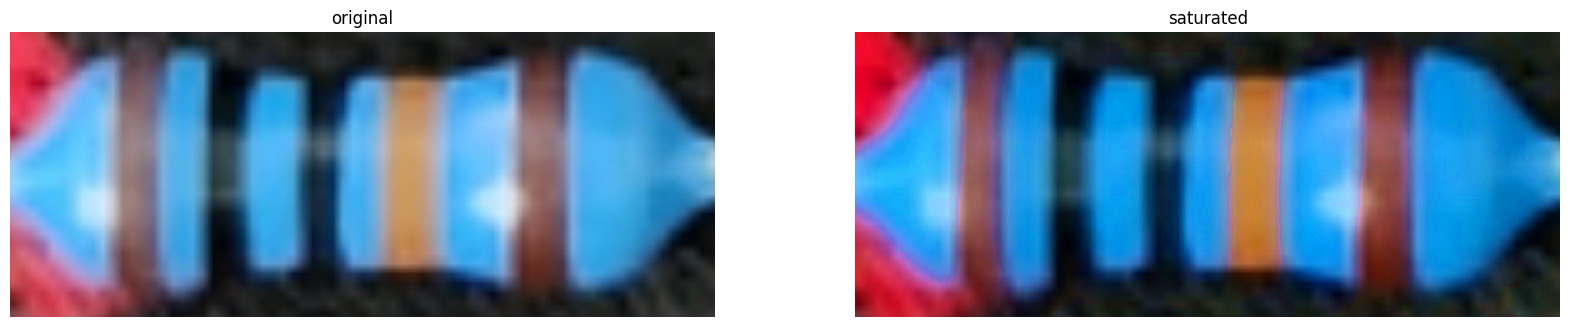

In [32]:
# ----- SATURATION EXPERIMENTS -----

def increase_saturation(image: cv.Mat, value=50):
    hsv_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)  # Convert image to HSV color space
    h, s, v = cv.split(hsv_image)  # Split the channels

    # Increase the saturation channel by the specified value
    s = cv.add(s, value)
    s = np.clip(s, 0, 255)  # Ensure that the pixel values are within the valid range

    hsv_image = cv.merge([h, s, v])  # Merge the channels back

    saturated_image = cv.cvtColor(hsv_image, cv.COLOR_HSV2BGR)  # Convert back to BGR color space

    return saturated_image

img = r1.img
img_sat = increase_saturation(img, 55)
plot_N_continuous(
    (img, 'original'),
    (img_sat, 'saturated')
)

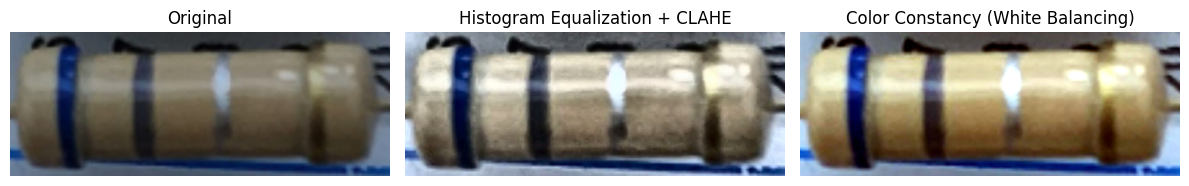

In [33]:
# ----- Color correction testing -----
import matplotlib.pyplot as plt

# Load the image
image = r4.img

# Convert the image to LAB color space
lab_image = cv.cvtColor(image, cv.COLOR_BGR2LAB)

# Split the LAB image into channels
L, A, B = cv.split(lab_image)

# Apply histogram equalization to the L channel
cv.equalizeHist(L, L)

# Create CLAHE object and apply it to the L channel
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
L = clahe.apply(L)

# Merge the channels back into LAB image
lab_image = cv.merge([L, A, B])

# Convert the LAB image back to BGR color space
equalized_image = cv.cvtColor(lab_image, cv.COLOR_LAB2BGR)

# Apply color constancy using white balancing
wb = cv.xphoto.createSimpleWB()
balanced_image = wb.balanceWhite(image)

# Apply Retinex algorithm for illumination normalization
# retinex = cv.xphoto.createSimpleRetinex()
# retinex_image = retinex.process(image)

# Create numpy arrays for displaying the images with pyplot
image_np = cv.cvtColor(image, cv.COLOR_BGR2RGB)
equalized_np = cv.cvtColor(equalized_image, cv.COLOR_BGR2RGB)
balanced_np = cv.cvtColor(balanced_image, cv.COLOR_BGR2RGB)

# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

axes[0].imshow(image_np)
axes[0].set_title('Original')

axes[1].imshow(equalized_np)
axes[1].set_title('Histogram Equalization + CLAHE')

axes[2].imshow(balanced_np)
axes[2].set_title('Color Constancy (White Balancing)')

# axes[3].imshow(cv.cvtColor(retinex_image, cv.COLOR_BGR2RGB))
# axes[3].set_title('Retinex')

# Remove the axis labels
for ax in axes:
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [34]:
# Cropping functions

def cropMiddle(image: cv.Mat, width_ratio=0.9, height_ratio=0.3):
    # Get the dimensions of the image
    height, width = image.shape[:2]

    # Calculate the new width and crop positions for the x-axis
    crop_width = int(width * width_ratio)
    left = int((width - crop_width) / 2)
    right = left + crop_width

    # Calculate the new height and crop positions for the y-axis
    crop_height = int(height * height_ratio)
    top = crop_height
    bottom = 2 * crop_height

    # Perform the crop
    cropped_image = image[top:bottom, left:right]

    return cropped_image


In [35]:
# Color correction
def apply_clahe(img):
    # Convert the image to LAB color space
    lab_image = cv.cvtColor(img, cv.COLOR_BGR2LAB)

    # Split the LAB image into channels
    L, A, B = cv.split(lab_image)

    # Create CLAHE object and apply it to the L channel
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    L = clahe.apply(L)

    # Merge the channels back into LAB image
    lab_image = cv.merge([L, A, B])

    # Convert the LAB image back to BGR color space
    equalized_image = cv.cvtColor(lab_image, cv.COLOR_LAB2BGR)

    return equalized_image

def apply_white_balance(img):
    # Apply white balancing
    wb = cv.xphoto.createSimpleWB()
    result_img = wb.balanceWhite(img)

    return result_img



### Brightening
To make the preprocessing more robust against variable lighting conditions, we need to test for brightness enhancing methods that work well for most images.

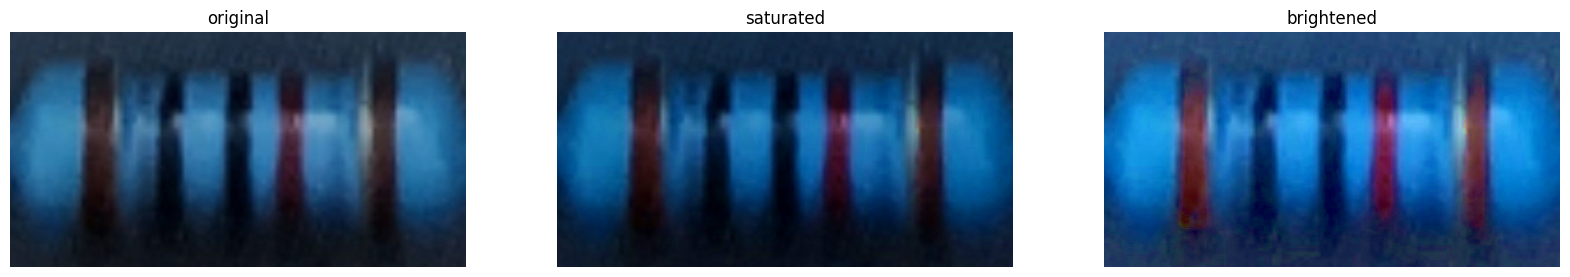

In [36]:
# ---- Brightness Adjustment ----

# Increases values such that brightness in HSV colorspace is within 0-255
def increase_brightness(image, value):
    hsv_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)  # Convert image to HSV color space
    h, s, v = cv.split(hsv_image)  # Split the channels

    # Increase the value channel by the specified value
    v = cv.add(v, value)
    v = np.clip(v, 0, 255)  # Ensure that the pixel values are within the valid range

    hsv_image = cv.merge([h, s, v])  # Merge the channels back

    brightened_image = cv.cvtColor(hsv_image, cv.COLOR_HSV2BGR)  # Convert back to BGR color space

    return brightened_image


def calculate_average_brightness(image: cv.Mat):
    hsv_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)  # Convert image to HSV color space
    v = hsv_image[:, :, 2]  # Extract the Value channel

    average_brightness = cv.mean(v)[0]  # Calculate the average brightness/luminance

    return average_brightness

# increases brightness of images if it falls beneath a threshold value
def adjust_brightness(image, brightness_threshold, brightness_increase):
    average_brightness = calculate_average_brightness(image)

    if average_brightness < brightness_threshold:
        brightened_image = increase_brightness(image, brightness_increase)
        return brightened_image
    else:
        return image

img = r2.img
img_sat = increase_saturation(img)
img_bright = increase_brightness(img_sat, 50)
plot_N_continuous(
    (img, 'original'),
    (img_sat, 'saturated'),
    (img_bright, 'brightened'),
) 


# Region & Contouring
If it is possible to directly extract regions of colour from the resistor, then we should 

One way to do this is through using 

Notice how "lighter" 

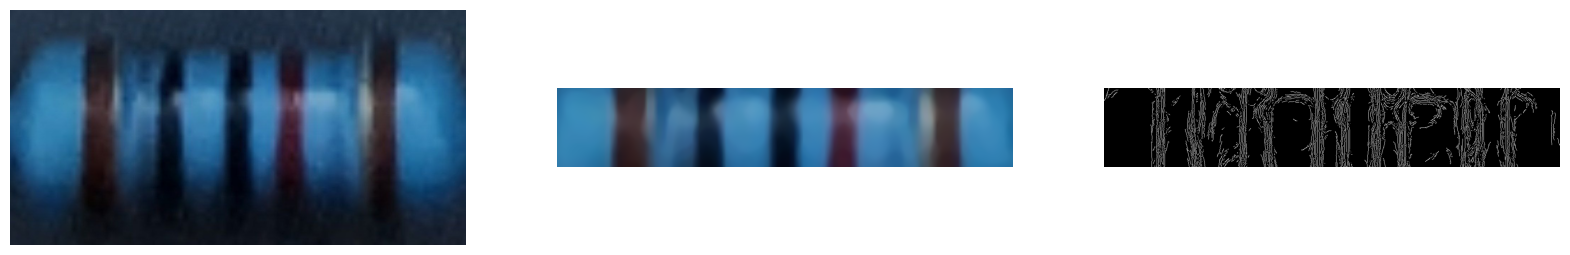

In [37]:
# ---- CANNY DETECTION ----

# Improve colors and make the image edges more pronounced for canny
img = r2.img
crop = cropMiddle(img)
med = cv.medianBlur(crop, 31)
canny = cv.Canny(med, 5, 15)
# gray = cv.cvtColor(crop, cv.COLOR_BGR2GRAY)
# blur = cv.GaussianBlur(gray, (5,5), 1)
# blur = cv.medianBlur(gray, 31)
# blur = cv.GaussianBlur(blur, (5,5), 0)
# thresh = cv.threshold(blur, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]
plot_N_continuous(
    (img, ''),
    (med, ''),
    (canny, '')
)

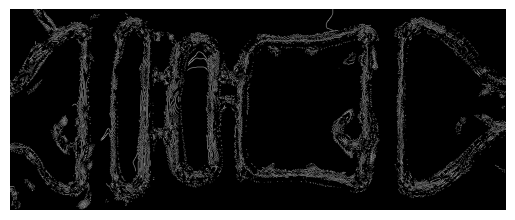

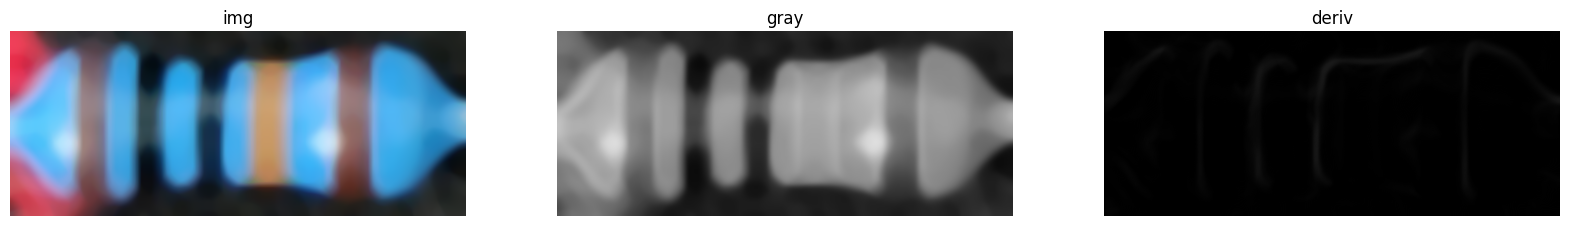

In [38]:
# ----- CONTOUR FINDING EXPERIMENTS ------

def sharpen(img):
    res = cv.GaussianBlur(img, (0, 0), 3)
    res = cv.addWeighted(res, 1.5, res, -0.5, 0, res)
    return res

def bilatFilter(img):
    # Use bilateral filtering
    di = 10 # diameter of pixel neighbourhood
    sigClr = 15 # stddev of colorspace.
    # neighbors with similar color val = more filter influence
    # This preserves edges while reducing noise. 
    sigSpace = 10 # stddev of coordinate space
    # larger val -> larger filter areas
    bilat = img.copy()
    bilat = cv.bilateralFilter(img, d=di, sigmaColor=sigClr, sigmaSpace=sigSpace)
    return bilat

img = r1.img
img = chosen_smoothing(img)
# plot(img)
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
# img_gray = chosen_smoothing(img_gray, 3)
img_gray = bilatFilter(img_gray)
img_gray = sharpen(img_gray)
canny = cv.Canny(img_gray, 1, 10)
plot(canny)

# scharr
# Sobel derivative
scale = 1
delta = 0
grad_x = cv.Sobel(img_gray, -1, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
grad_y = cv.Sobel(img_gray, -1, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
# We can use the scharr kernel instead
grad_x_schar = cv.Sobel(img_gray, -1, 1, 0, ksize=cv.FILTER_SCHARR)
grad_y_schar = cv.Sobel(img_gray, -1, 0, 1, ksize=cv.FILTER_SCHARR)
# Approximate the gradient by adding them together
# There are other methods of doing this
res = cv.addWeighted(grad_x, 0.5, grad_y, 0.5, 0)
res_scharr = cv.addWeighted(grad_x_schar, 0.5, grad_y, 0.5, 0)


plot_N_continuous(
    (img, 'img'),
    (img_gray, 'gray'),
    (res, 'deriv')
)

# Reducing the problem
Instead of trying to find regions and deal with the varying amounts of noise on 2 axes per photo, it is entirely possible to reduce the problem to 1 dimension. This can be done through custom filtering of the image.

brown-black-black-brown-brown
(148, 1151, 3)


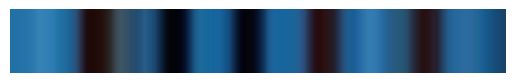

In [39]:
# ------ SIMPLYFYING IMAGE EXPERIMENTS ------

def columnMedianReplace(img: cv.Mat):
    imgClean = img.copy()
    rows, cols, _ = img.shape
    for col in range(0, cols):
        colVals = imgClean[:, col, :]
        medianValue = np.median(colVals, axis=0)
        imgClean[:, col, :] = medianValue
    return imgClean

def columnMedianReplaceStep(img: cv.Mat, sz=3):
        # Get the dimensions of the image
        height, width, _ = img.shape
        # Create a copy of the image
        new_img = img.copy()
        # Iterate over every N columns
        for col in range(0, width, sz):
            # Determine the range of columns to process
            start_col = col
            end_col = min(col + sz, width)
            # Extract the region of interest (ROI)
            roi = img[:, start_col:end_col]
            # Calculate the median RGB color for the ROI
            median_color = np.median(roi, axis=(0, 1))
            median_color = np.uint8(median_color)
            # Replace all pixels in the N columns with the median color
            new_img[:, start_col:end_col] = median_color
        return new_img

chosenR = r3
myImg = chosenR.img
# myImg = cv.medianBlur(myImg, 11)
# for i in range(0, 3):
myImg = cropMiddle(myImg, 0.9, 0.3)
# myImg = columnMedianReiplace(myImg)
myImg = columnMedianReplaceStep(myImg, 3)
# myImg = cv.medianBlur(myImg, 61)
    # myImg = cv.GaussianBlur(myImg, (3,3), 1.2)

print(chosenR.name)
print(myImg.shape)
plot(myImg)

In [40]:
def replace_column_with_average(image, N):
    # Reshape the image to a 2D array of pixels
    pixels = image.reshape(-1, 3)
    
    # Get the width of the image
    width = image.shape[1]
    
    # Iterate over each column
    for col in range(0, width):
        # Get the pixels in the current column
        column_pixels = pixels[col::width]
        
        # Calculate the frequency of colors in the column
        unique_colors, counts = np.unique(column_pixels, axis=0, return_counts=True)
        
        # Sort the colors based on their frequencies
        sorted_indices = np.argsort(-counts)
        sorted_colors = unique_colors[sorted_indices]
        
        # Get the N most frequent colors in the column
        most_frequent_colors = sorted_colors[:N]
        
        # Calculate the average color of the N most frequent colors
        average_color = np.mean(most_frequent_colors, axis=0)
        
        # Replace all pixels in the column with the average color
        column_pixels[:] = average_color
    
    # Reshape the modified pixels back to the original image shape
    modified_image = pixels.reshape(image.shape)
    
    return modified_image

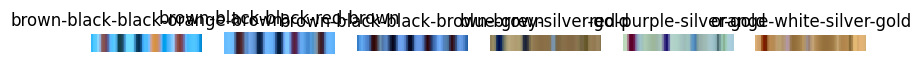

In [41]:
# Crop, clean, blur
import copy
def process_image(img: cv.Mat):
    img_copy = copy.deepcopy(img)  # Create a deep copy of the image
    img_copy = increase_brightness(img, 20)
    img_copy = increase_saturation(img_copy, 40)
    img_copy = apply_clahe(img_copy)
    img_copy = cropMiddle(img_copy, width_ratio=0.85, height_ratio=0.33)  
    img_copy = columnMedianReplaceStep(img_copy, 20)
    # img_copy = replace_column_with_average(img, 1)
    return img_copy

processed = copy.deepcopy(resistors)
for i, r in enumerate(processed):
    # print(processed[i].img)
    processed[i].img = process_image(processed[i].img)
plot_N_resistors(processed)

The cell below is an attempt to try to extract the color bands using simple K-means clustering

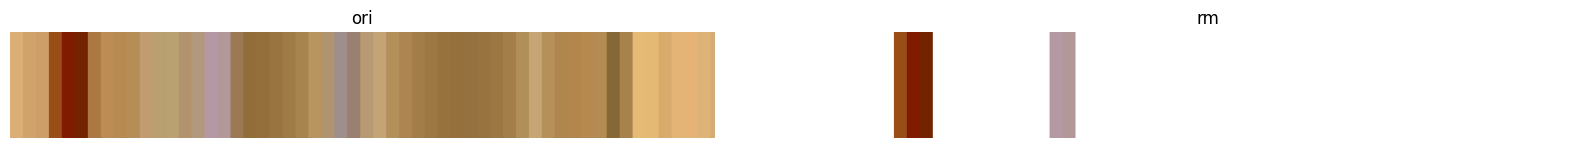

In [42]:
def remove_background(image):
    # Reshape the image to a 2D array of pixels
    pixels = image.reshape(-1, 3).astype(np.float32)
    
    # Define the criteria for K-means clustering
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    
    # Perform K-means clustering
    _, _, centers = cv.kmeans(pixels, 1, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
    background_color = centers[0].astype(int)
    
    # Define the threshold for color similarity (adjust as needed)
    similarity_threshold = 55
    
    # Calculate color similarity with the background color
    color_diff = np.abs(pixels - background_color)
    similarity_mask = np.all(color_diff < similarity_threshold, axis=1)
    
    # Replace similar colors with a placeholder color
    placeholder_color = (255, 255, 255)  # Replace with desired placeholder color
    pixels[similarity_mask] = placeholder_color
    
    # Reshape the modified pixels back to the original image shape
    modified_image = pixels.reshape(image.shape)
    modified_image = modified_image.astype(np.uint8)
    
    return modified_image

img = r6.img
img = process_image(img)
img_rm = remove_background(img)
plot_N_continuous(
    (img, 'ori'),
    (img_rm, 'rm')
) 

# Conclusions

From these experiments and playing around with different images for the same function, I learnt that...
1. Contour detection is not reliable and generalizable for images of different lighting
2. The problem is reducible to a 1 dimensional problem which will help to ease labelling 

## Next steps
Labelling of preprocessed data for the color classifier to learn from